In [1]:
import numpy as np
import random
import cv2
from PIL import ImageColor, Image
import matplotlib.pyplot as plt
import glob
from patchmaker import PatchMaker
import joblib

**Sources:**<br>
Image_patches: https://www.youtube.com/watch?v=7IL7LKSLb9I&t=376s&ab_channel=DigitalSreeni<br>
Image_patches2: https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python<br>
VGG19 UNet: https://www.youtube.com/watch?v=2D5WLsrc-Go&t=8s&ab_channel=IdiotDeveloper<br>
Multiclass semantic segmentation using U-Net: https://www.youtube.com/watch?v=XyX5HNuv-xE&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=13&ab_channel=DigitalSreeni<br>

In [2]:
# Directory location where the dataset is stored
images_path = glob.glob('./Semantic segmentation dataset/**/images/*')
masks_path = glob.glob('./Semantic segmentation dataset/**/masks/*')

In [3]:
def create_arrays_from_pic_path(path:str)-> np.ndarray:
    ''' Takes a directory path and returns an array of images/masks
        ===========================================================
        Reads the image from path, converts it to RGB, resizes it 500x500
    '''
    images = []
    for image in path:
        im = cv2.imread(image, 1)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (512,512), interpolation = cv2.INTER_NEAREST)
        images.append(im)
    return np.array(images)

In [4]:
images_array = create_arrays_from_pic_path(path=images_path)
masks_array = create_arrays_from_pic_path(path=masks_path)

In [5]:
images_array.shape, masks_array.shape

((72, 512, 512, 3), (72, 512, 512, 3))

In [6]:
# Copied from the Kaggle Content section -> do not use the provied json file 
# Convert colour Hex values to RGB values
hex_classes = { 'Building': '#3C1098',
                'Land': '#8429F6',
                'Road': '#6EC1E4',
                'Vegetation': '#FEDD3A',
                'Water': '#E2A929',
                'Unlabeled': '#9B9B9B'}

class_color_RGB = {classs:ImageColor.getcolor(hex_classes[classs], "RGB") for classs in hex_classes}
class_color_RGB

{'Building': (60, 16, 152),
 'Land': (132, 41, 246),
 'Road': (110, 193, 228),
 'Vegetation': (254, 221, 58),
 'Water': (226, 169, 41),
 'Unlabeled': (155, 155, 155)}

In [7]:
# Array representation of RGB values
RGB_ARR = rgb_arr = np.array([*class_color_RGB.values()])
RGB_ARR

array([[ 60,  16, 152],
       [132,  41, 246],
       [110, 193, 228],
       [254, 221,  58],
       [226, 169,  41],
       [155, 155, 155]])

In [8]:
# Check to see if the masks contain any RGB values that are not in the RGB_ARR
row_arr = masks_array.reshape(-1, 3)
clean_masks_array = np.where(np.isin(row_arr, RGB_ARR), row_arr, [155, 155, 155])
masks_array = clean_masks_array.reshape(masks_array.shape)

Plot a single images and corresponding mask

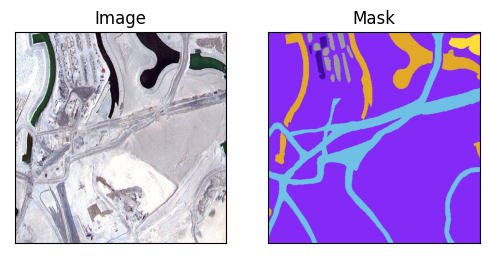

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,8))
rand_index = 0
ax1.imshow(images_array[rand_index])
ax1.set_title("Image")
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.imshow(masks_array[rand_index])
ax2.set_title("Mask")
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.show()

Split the data into train and test

In [10]:
# Keep the last tile as the test -> the rest for training
x_train, x_val, x_test = images_array[:-18], images_array[-18:-9], images_array[-9:]
y_train, y_val, y_test = masks_array[:-18], masks_array[-18:-9], masks_array[-9:]

In [11]:
x_train.shape, x_val.shape, x_test.shape

((54, 512, 512, 3), (9, 512, 512, 3), (9, 512, 512, 3))

In [12]:
y_train.shape, y_val.shape, y_test.shape

((54, 512, 512, 3), (9, 512, 512, 3), (9, 512, 512, 3))

Data augmentation 

In [13]:
# Split the images and masks into smaller patches
pm = PatchMaker()
x_train_patches = np.array([pm.split(arr, (128,128,3), 128) for arr in x_train])
y_train_patches = np.array([pm.split(arr, (128,128,3), 128) for arr in y_train])
x_val_patches = np.array([pm.split(arr, (128,128,3), 128) for arr in x_val])
y_val_patches = np.array([pm.split(arr, (128,128,3), 128) for arr in y_val])

assert(x_train_patches.shape == y_train_patches.shape), "Images and masks are not the same shape"
assert(x_val_patches.shape == y_val_patches.shape), "Val images and masks are not the same shape"

In [14]:
# Reshap from (63, 25, 100, 100, 3) -> (num_images, 100, 100, 3) 
x_train_4d = x_train_patches.reshape(x_train_patches.shape[0] * x_train_patches.shape[1], 128, 128, 3)
y_train_4d = y_train_patches.reshape(y_train_patches.shape[0] * y_train_patches.shape[1], 128, 128, 3)
x_val_4d = x_val_patches.reshape(x_val_patches.shape[0] * x_val_patches.shape[1], 128, 128, 3)
y_val_4d = y_val_patches.reshape(y_val_patches.shape[0] * y_val_patches.shape[1], 128, 128, 3)

x_train_4d.shape, y_train_4d.shape, x_val_4d.shape, y_val_4d.shape

((864, 128, 128, 3),
 (864, 128, 128, 3),
 (144, 128, 128, 3),
 (144, 128, 128, 3))

Visualize the patches

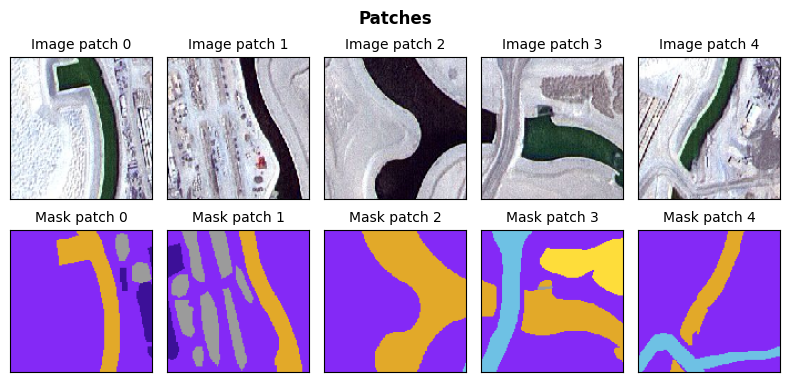

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle("Patches", weight='heavy')
for j in range(5):
    axs[0,j].imshow(x_train_4d[j])
    axs[0,j].set_title(f'Image patch {j}', fontsize=10)
    axs[0,j].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

    axs[1,j].imshow(y_train_4d[j])
    axs[1,j].set_title(f'Mask patch {j}', fontsize=10)
    axs[1,j].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

fig.tight_layout()
plt.subplots_adjust(top=.90)
plt.show()

Rotate images and masks 

In [16]:
def rotate_patches(patches:np.ndarray) -> np.ndarray:
    ''' Takes a collection of image arrays rotates them 90, -90, 180 degrees 
    '''
    assert patches.ndim == 4, "Patches should be a 4D array -> (1575, 100, 100, 3)"
    arr_list = []
    for img in patches:
        arr_list.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
        arr_list.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
        arr_list.append(cv2.rotate(img, cv2.ROTATE_180))
    return np.array(arr_list)

In [17]:
rotated_x_train = rotate_patches(x_train_4d)
rotated_y_train = rotate_patches(y_train_4d)
rotated_x_val = rotate_patches(x_val_4d)
rotated_y_val = rotate_patches(y_val_4d)

assert(rotated_x_train.shape == rotated_y_train.shape), "Images and masks are not the same shape" 
assert(rotated_x_val.shape == rotated_y_val.shape), "Val images and masks are not the same shape" 

Visualize the rotated patches

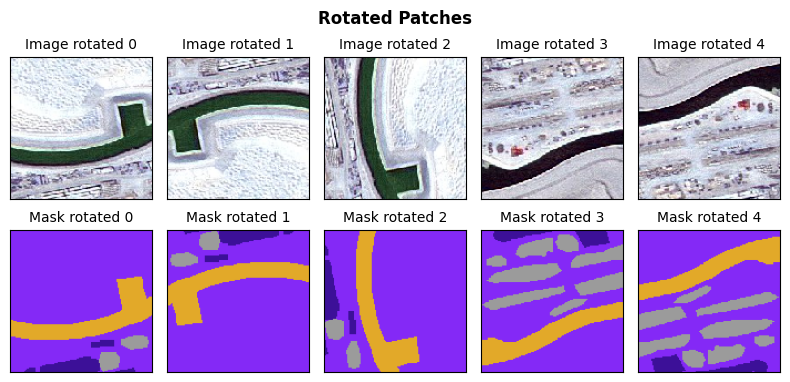

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle("Rotated Patches", weight='heavy')
for j in range(5):
    axs[0,j].imshow(rotated_x_train[j])
    axs[0,j].set_title(f'Image rotated {j}', fontsize=10)
    axs[0,j].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

    axs[1,j].imshow(rotated_y_train[j])
    axs[1,j].set_title(f'Mask rotated {j}', fontsize=10)
    axs[1,j].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

fig.tight_layout()
plt.subplots_adjust(top=.90)
plt.show()

Add the rotated patches to the original patches

In [19]:
# Add the rotated patches to the original patches array
x_train = np.concatenate((x_train_4d.flatten(), rotated_x_train.flatten()), dtype=np.float32).reshape(-1, 128,128,3)
y_train = np.concatenate((y_train_4d.flatten(), rotated_y_train.flatten()), dtype=np.float32).reshape(-1, 128,128,3)
x_val = np.concatenate((x_val_4d.flatten(), rotated_x_val.flatten()), dtype=np.float32).reshape(-1, 128,128,3)
y_val = np.concatenate((y_val_4d.flatten(), rotated_y_val.flatten()), dtype=np.float32).reshape(-1, 128,128,3)

assert(x_train.shape == y_train.shape), "Images and masks are not the same shape" 
assert(x_val.shape == y_val.shape), "Val images and masks are not the same shape" 

Convert the masks from RGB to scalar

In [20]:
def rgb2scalar(arr_3d:np.ndarray, rgb_vals:np.ndarray) -> np.ndarray:
    ''' Takes an 3D array of RGB values and replaces 
        each 3D array with an int corresponding to a colour and 
        returns a 2D array '''

    assert arr_3d.ndim == 3, "The dimensions need to be -> (100,100,3)"
    result = np.empty(arr_3d.shape[:2], dtype=np.int8) # Drop the channal dim

    for i, rgb in enumerate(rgb_vals):
        result[(arr_3d == rgb).all(2)] = i
    
    '''4D array: 
    res = np.empty(y_train.shape[:-1])
        for i, rgb_vals in enumerate(RGB_ARR):
        res[(y_train==rgb_vals).all(-1)] = i 
    '''
    
    return result

In [21]:
def scalar2rgb(arr2d:np.ndarray, rgb_vals:np.ndarray) -> np.ndarray:
    ''' Takes a 2D array of scalar values and replaces
        each value with RGB values and returns a 3D array
        =================================================
        colors -> RGB values in an array
        Each arr2d[row, col] will yield a single scalar value
        that will be used by colors to return a RGB result'''
    
    return rgb_vals[arr2d]

In [22]:
y_train_scalar = np.array([rgb2scalar(arr_3d=arr, rgb_vals=RGB_ARR) for arr in y_train])
y_val_scalar = np.array([rgb2scalar(arr_3d=arr, rgb_vals=RGB_ARR) for arr in y_val])

Convert to categorical

In [23]:
from keras.utils import to_categorical, normalize

In [24]:
y_train_cat = to_categorical(y=y_train_scalar, num_classes=RGB_ARR.shape[0])
y_val_cat = to_categorical(y=y_val_scalar, num_classes=RGB_ARR.shape[0])

# To reverse to_categorical -> (np.argmax(y_train_cat[0],axis=-1) == y_train_scalar[0]).all()

In [25]:
x_train = normalize(x_train)
x_val = normalize(x_val)

In [26]:
x_train.shape, y_train_cat.shape, x_val.shape, y_val_cat.shape

((3456, 128, 128, 3),
 (3456, 128, 128, 6),
 (576, 128, 128, 3),
 (576, 128, 128, 6))

In [27]:
x_train.dtype, y_train_cat.dtype, x_val.dtype, y_val_cat.dtype

(dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'))

In [28]:
# Save to file
np.save('x_train', x_train)
np.save('y_train', y_train_cat)
np.save('x_val', x_val)
np.save('y_val', y_val_cat)

Load model from disk

In [29]:
import tensorflow as tf
from tensorflow import keras

### Segmentation Models<br>
Backbone: resnet34<br>
Encoder weights: imagenet<br>
Encoder weights frozen -> not trained 

In [30]:
# Trained for 500 epochs
model = keras.models.load_model(r'./training3/')

In [32]:
# Patchify images from (510,510,3) -> (128,128,3)
x_test_patches = np.array([pm.split(arr, (128,128,3), 128) for arr in x_test])
x_test_patches.shape

(9, 16, 128, 128, 3)

In [33]:
# Reshape to (num_images, 128, 128, 3)
x_test_4d = x_test_patches.reshape(x_test_patches.shape[0] * x_test_patches.shape[1], 128, 128, 3)
x_test_4d.shape

(144, 128, 128, 3)

In [34]:
# Normalize the test images
x_test_norm = normalize(x_test_4d)

In [ ]:
y_hat = model.predict(x_test_norm)
y_hat.shape

In [47]:
y_pred_argmax = np.argmax(y_hat, axis=3)
y_pred_argmax.shape

(144, 128, 128)

In [48]:
y_pred_scalar = np.array([scalar2rgb(arr2d=arr, rgb_vals=RGB_ARR) for arr in y_pred_argmax])
y_pred_scalar.shape

(144, 128, 128, 3)

In [41]:
y_pred_reshaped = y_pred_scalar.reshape(x_test_patches.shape)
y_pred_reshaped.shape

(9, 16, 128, 128, 3)

In [42]:
y_pred_unpatched = np.array([pm.join(split_arr=arr) for arr in y_pred_reshaped])
y_pred_unpatched.shape

(9, 512, 512, 3)

Visualize the predictions vs the actuals

In [44]:
from skimage.metrics import mean_squared_error

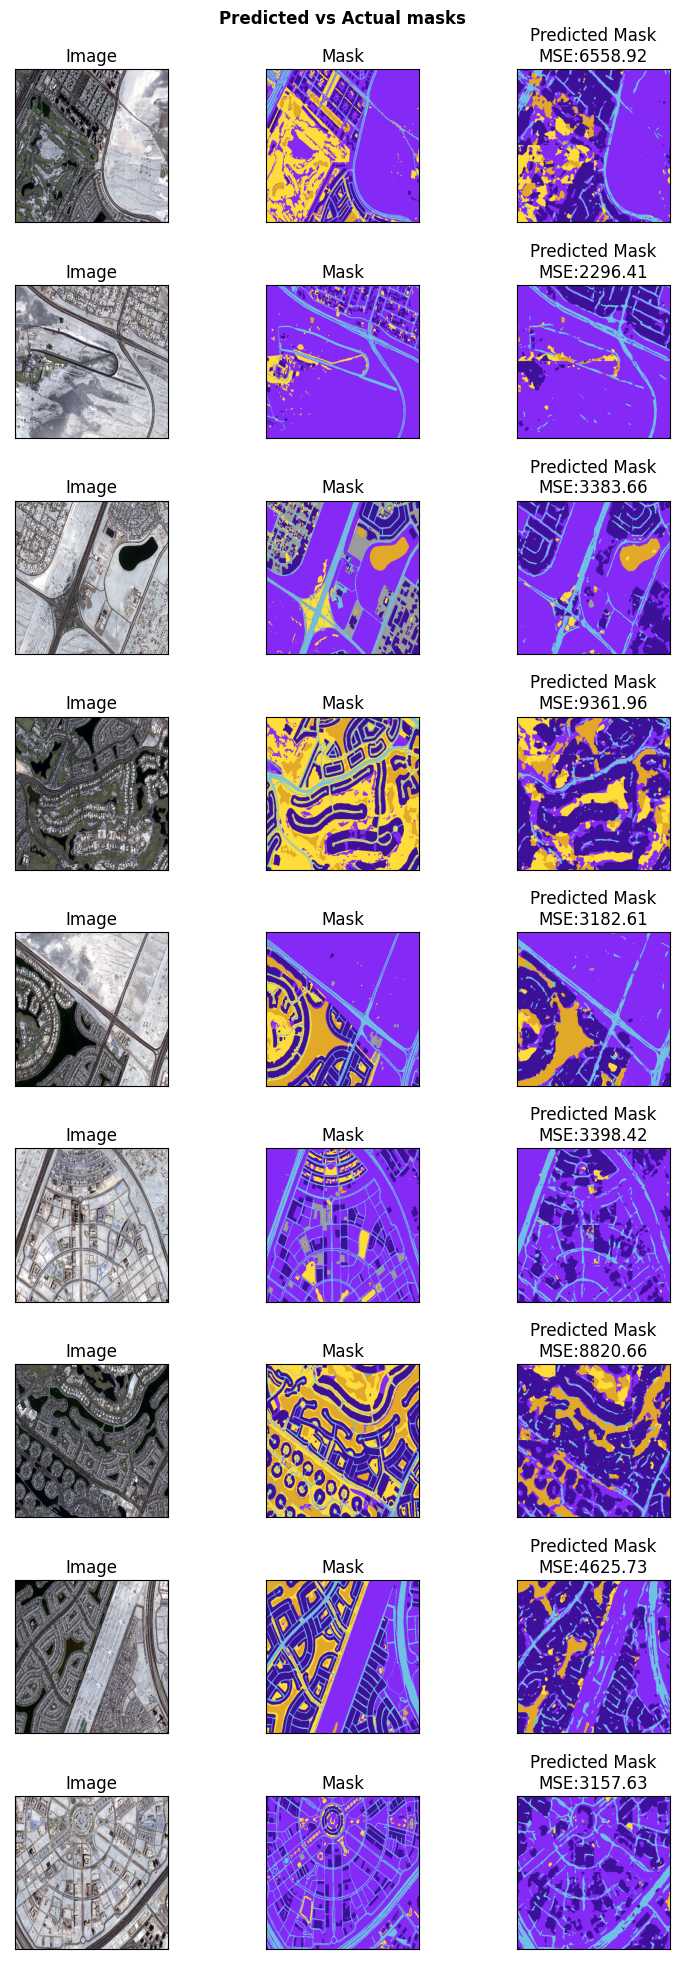

In [45]:
fig, axs = plt.subplots(x_test.shape[0], 3, figsize=(8,20))
fig.suptitle("Predicted vs Actual masks", weight='heavy')
for i in range(x_test.shape[0]):
    axs[i][0].imshow(x_test[i])
    axs[i][0].set_title("Image")
    axs[i][0].axes.xaxis.set_visible(False)
    axs[i][0].axes.yaxis.set_visible(False)
    axs[i][1].imshow(y_test[i])
    axs[i][1].set_title("Mask")
    axs[i][1].axes.xaxis.set_visible(False)
    axs[i][1].axes.yaxis.set_visible(False)
    axs[i][2].imshow(y_pred_unpatched[i])
    mse = mean_squared_error(y_test[i], y_pred_unpatched[i])
    axs[i][2].set_title(f"Predicted Mask\nMSE:{mse:.2f}")
    axs[i][2].axes.xaxis.set_visible(False)
    axs[i][2].axes.yaxis.set_visible(False)

fig.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()